# Optimal Transport for single-cell omics

This Jupyter Notebook will walk you trough the code to replicate the experiments from our research on applying OT as a loss function in between single-cell omics data. `bioRxiv link here`.

The code is designed to be run on GPU. If you do not have access to a GPU you may want to use the (free) Google Colab to run this notebook.

## Imports

General libraries to load data, do computations and make plots.

In [ ]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

Function to compute pairwise distance matrices for various functions (e.g. euclidean, cosine ...)

In [ ]:
from scipy.spatial.distance import cdist

Clustering models used for evaluation

In [ ]:
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

Metrics used for scoring

In [1]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

Library `tqdm` makes pretty progress bars.

In [ ]:
from tqdm.notebook import tqdm

## Load preprocessed data

We provide preprocessed data as compressed csv files, with features as rows and cell as columns. The target classes (cell type or cell line) are given in the column name.

In [2]:
# Load the data
data = pd.read_csv('liu_scrna_preprocessed.csv.gz', index_col=0)

In [3]:
# Retrive clusters
clusters = np.array([col.split('_')[-1] for col in data.columns])
idx = np.argsort(clusters) # Sorted indices (for visulization)

In [4]:
# Display unique clusters
np.unique(clusters)

array(['HCT', 'Hela', 'K562'], dtype='<U4')

We select 10,000 most varying features, if the dataset has more features than that.

In [5]:
# Select 10k most varying features
data = data.iloc[np.argsort(data.std(1))[::-1][:10_000]]

The data can optionally be normalized per-cell, and the features can be scaled to unit variance. In general this does not bring improvements.

In [6]:
# Uncomment below for per-cell normalization
#data /= data.sum(0)

# Uncomment below for per-cell normalization and feature scaling
#data /= data.sum(0)
#data = data.T
#data /= data.std(0)
#data = data.T

Converting the dataset to a numpy array for the rest of the analysis.

In [7]:
# From pandas to NumPy
data = np.array(data)

## Code for OT

In this section we implement the functions used to compute OT and baseline distance matrices.

Computing the cost matrix (i.e. a distance matrix between features).

In [8]:
def cost_matrix(data, cost, normalize_features=True):
  """
  Compute cost matrix on input `data` for function `cost`
  Features are normalized by default (`normalize_features`)
  """
  if normalize_features:
    sums = data.sum(1).reshape(-1, 1)
    C = cdist(data/sums, data/sums, metric=cost)
  else:
    C = cdist(data, data, metric=cost)
  return C/C.max()

Computing the distance matrix between cells.

In [9]:
def distance_matrix(data, metric):
  """Compute pairwise distance matrix on input `data` for function `metric`"""
  D = cdist(data.T, data.T, metric=metric)
  return D/D.max()

Retreiving the indices of lower triangle of a symmetric matrix. That avoids to do the computations twice.

In [10]:
def tri_idx(n):
  """
  Indices of lower triangle of a `n`*`n` matrix.
  Used for batching the computation of pairwise distance matrices.
  """
  idx_i, idx_j = [], []
  for i in range(n):
    for j in range(i):
      idx_i.append(i)
      idx_j.append(j)
  return np.array(idx_i), np.array(idx_j)

Splitting a list of indices in batches, in order to batch distance computations.

In [11]:
def split(a, n):
  """
  Make `n` batches from an array `a`.
  Used for batching the computation of pairwise distance matrices.
  """
  res = []
  k = int(np.ceil(len(a)/n))
  i = 0
  while i*k < len(a):
    res.append(a[i*k : min(i*k + k, len(a))])
    i += 1
  return res

Now the workhorse of this notebook. The following function implements the Sinkhorn algorithm on GPU, and return the debiased Sinkhorn divergence. We use the dual formulation. Finally, by making `u` and `v` matrices instead of vectors we can compute several distances at the same time (parallelization). For more details on implementing OT, please refer to https://www.numerical-tours.com/python/. You may also want to use an existing library like POT (https://pythonot.github.io/).

In [12]:
def OT_distance_matrix(data_np, cost_C, eps=.1, n_iter=5,\
                       n_batches=10, dtype=torch.float32):
  """
  Compute OT distance matrix.
  `data_np`: data as a NumPy matrix (on CPU)
  `cost_C`: cost matrix as a NumPy array (on CPU)
  `eps`: regularization parameter
  `n_iter`: how many iterations of the Sinkhorn algorithm
  `n_batches`: how many batches for the computation (more batches, less memory)
  `dtype`: should be `torch.float32` or `torch.double`
  For small values of `epsilon`, `n_iter` should be bigger to converge better
  In order to use OT in your own application, you may want to consider the more
  flexible and canonical tool POT (https://pythonot.github.io/)
  """
  # Compute K (inplace)
  C = torch.from_numpy(cost_C)
  C = C.to(device=torch.device('cuda:0'), dtype=dtype)
  
  C.mul_(-1/eps);
  C.exp_();

  data = torch.from_numpy(data_np)
  data = data.to(device=torch.device('cuda:0'), dtype=dtype)

  # Compute diagonal
  v = torch.ones(data.shape, device=torch.device('cuda:0'), dtype=dtype)
  u = torch.ones(data.shape, device=torch.device('cuda:0'), dtype=dtype)

  for _ in range(n_iter):
    torch.matmul(C, v, out=u)
    u.pow_(-1).mul_(data)

    torch.matmul(C, u, out=v)
    v.pow_(-1).mul_(data)

  d = -0.5*eps*((torch.log(u)*data).sum(0) + (torch.log(v)*data).sum(0) - ((C @ u) * v).sum(0))

  # Unbias distance matrix
  diagonal = d.cpu()
  D = diagonal.view(-1, 1) + diagonal.view(1, -1)
  D[range(len(D)), range(len(D))] = 0

  # Define batches
  idx_i, idx_j = tri_idx(data.shape[1])
  idx_i = split(idx_i, n_batches)
  idx_j = split(idx_j, n_batches)

  for k in tqdm(range(n_batches)):
    v = torch.ones(data[:,idx_j[k]].shape, device=torch.device('cuda:0'), dtype=dtype)
    u = torch.ones(data[:,idx_i[k]].shape, device=torch.device('cuda:0'), dtype=dtype)
    for _ in range(n_iter):
      torch.matmul(C, v, out=u)
      u.pow_(-1).mul_(data[:,idx_i[k]])

      torch.matmul(C, u, out=v)
      v.pow_(-1).mul_(data[:,idx_j[k]])

    d = eps*((torch.log(u)*data[:,idx_i[k]]).sum(0) + (torch.log(v)*data[:,idx_j[k]]).sum(0) - ((C @ u) * v).sum(0)).cpu()

    D[idx_i[k], idx_j[k]] += d
    D[idx_j[k], idx_i[k]] += d

  D /= torch.max(D)
  
  return D.numpy()

## Compute distance matrix

In this section we will compute distance matrices between cells using both Optimal Transport and the Euclidean distance.

### Compute baseline distance matrix

Let us start by compute the euclidean distance matrix. You may change the following line of code using `cityblock`, `cosine`, `correlation` or any Scipy-compatible distance.

In [13]:
# Replace `euclidean` with any scipy distance metric
D_eu = distance_matrix(data, 'euclidean')

Displaying the distance matrix, with cells ordered by class. Clusters should be visible in the form of diagonal blocks of close distances.

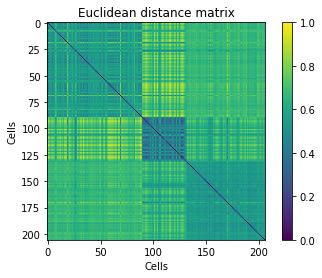

In [14]:
plt.imshow(D_eu[idx][:,idx])
plt.title('Euclidean distance matrix')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.colorbar()
plt.show()

### Compute OT distance matrix

Now on the OT distance matrix. We first need to normalize cells (divide columns by their sum). This is because Optimal Transport works on probability distributions. We then compute a cost matrix (you may change `cosine` by another function) and the associated OT distance matrix.

In [15]:
# Per-cell normalization (mandatory)
data_norm = data/data.sum(0)

# Add a small value to avoid numerical errors
data_norm += 1e-6
data_norm /= data_norm.sum(0)

# Compute cost matrix
C = cost_matrix(data, 'cosine')

# Compute OT distance matrix
D_ot = OT_distance_matrix(data_norm, C, eps=.1, n_iter=5, n_batches=50, dtype=torch.float32)
D_ot[D_ot < 0] = 0 # Enforce positivity, just in case

Displaying the OT distance matrix, with cells ordered by class. Clusters should be visible in the form of diagonal blocks of low distances.

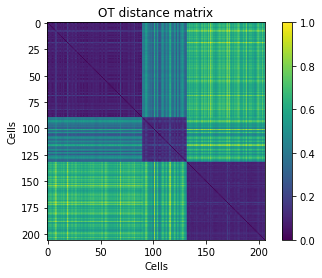

In [16]:
plt.imshow(D_ot[idx][:,idx])
plt.title('OT distance matrix')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.colorbar()
plt.show()

## Code for scoring metrics

The following function computes the C index, a score that evaluates how well distance matrices match with ground truth clusters.

In [17]:
def C_index(D, clusters):
  """
  Compute C index given:
  - a distance matrix `D`
  - cluster assignments `clusters`
  
  Value between 0 (best) and 1 (worst)
  """
  Sw = Nw = 0
  for c in np.unique(clusters):
    idx = np.where(clusters == c)[0]
    Sw += D[idx][:,idx].sum()/2
    Nw += int(len(idx)*(len(idx) - 1)/2)

  els = []
  for i in range(len(D)):
    for j in range(i):
      els.append(D[i, j])
  Smin = np.sort(np.array(els))[:Nw].sum()
  Smax = np.sort(np.array(els))[::-1][:Nw].sum()

  return (Sw - Smin)/(Smax - Smin)

## Scoring

Let us compare the score for both distance matrices.

### Silhouette score

In [18]:
print('Euclidean\t',  silhouette_score(D_eu, clusters, metric='precomputed'))
print('OT\t\t',       silhouette_score(D_ot, clusters, metric='precomputed'))

Euclidean	 0.1820584681790864
OT		 0.76920503


### C index

In [19]:
print('Euclidean\t',  C_index(D_eu, clusters))
print('OT\t\t',       C_index(D_ot, clusters))

Euclidean	 0.07475132621587204
OT		 4.822934432795685e-05


### Hierarchical clustering (fixed number of clusters)

We first cluster cells based on hierarchical clustering, fixed the number of clusters to the number of classes in the ground truth.

In [20]:
cl = AgglomerativeClustering(affinity='precomputed',\
                n_clusters=len(np.unique(clusters)), linkage='complete')

In [21]:
print('Euclidean')
cl.set_params().fit(D_eu)
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

Euclidean
ARI 0.8965241937345635
NMI 0.8684912350021982
AMI 0.867262223633008


In [22]:
print('OT')
cl.set_params().fit(D_ot)
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

OT
ARI 1.0
NMI 1.0
AMI 1.0


### Hiarchical clustering (number of clusters derived from silhouette)

A more realistic setting is to find the "optimal" number of clusters in an unsupervised way. We run the clustering for every number of clusters between 3 and 25, and select the clustering yielding the best silhouette score.

In [23]:
cl = AgglomerativeClustering(affinity='precomputed', linkage='complete')

range_clusters, sil = range(3, 26), []

# Iterate through numbers of clusters
for n_clusters in range_clusters:
  cl.set_params(n_clusters=n_clusters).fit(D_eu)
  sil.append(silhouette_score(D_eu, cl.labels_, metric='precomputed'))

# Select the number yielding best silhouette
cl.set_params(n_clusters=range_clusters[np.argmax(sil)]).fit(D_eu)

print('Euclidean,', range_clusters[np.argmax(sil)], 'clusters')
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

Euclidean, 3 clusters
ARI 0.8965241937345635
NMI 0.8684912350021982
AMI 0.867262223633008


In [24]:
cl = AgglomerativeClustering(affinity='precomputed', linkage='complete')

range_clusters, sil = range(3, 26), []

# Iterate through numbers of clusters
for n_clusters in range_clusters:
  cl.set_params(n_clusters=n_clusters).fit(D_ot)
  sil.append(silhouette_score(D_ot, cl.labels_, metric='precomputed'))

# Select the number yielding best silhouette
cl.set_params(n_clusters=range_clusters[np.argmax(sil)]).fit(D_ot)

print('OT,', range_clusters[np.argmax(sil)], 'clusters')
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

OT, 3 clusters
ARI 1.0
NMI 1.0
AMI 1.0


### Spectral clustering (fixed number of clusters)

We also use spectral clustering in the same way, first with fixed number of clusters.

In [25]:
# `cl` takes as input `1-D` (affinity) instead of `D` (distance)
cl = SpectralClustering(affinity='precomputed',\
                        n_clusters=len(np.unique(clusters)))

In [26]:
print('Euclidean')
cl.set_params().fit(1-D_eu)
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

Euclidean
ARI 0.8397177367143156
NMI 0.7962187745080864
AMI 0.7942938038876559


In [27]:
print('OT')
cl.set_params().fit(1-D_ot)
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

OT
ARI 1.0
NMI 1.0
AMI 1.0


### Spectral clustering (number of clusters derived from silhouette)

... and then with a silhouette-derived number of clusters.

In [28]:
cl = SpectralClustering(affinity='precomputed')

range_clusters, sil = range(3, 26), []

# Iterate through numbers of clusters
for n_clusters in range_clusters:
  cl.set_params(n_clusters=n_clusters).fit(1 - D_eu)
  sil.append(silhouette_score(D_eu, cl.labels_, metric='precomputed'))

# Select the number yielding best silhouette
cl.set_params(n_clusters=range_clusters[np.argmax(sil)]).fit(1 - D_eu)

print('Euclidean,', range_clusters[np.argmax(sil)], 'clusters')
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

Euclidean, 3 clusters
ARI 0.8397177367143156
NMI 0.7962187745080864
AMI 0.7942938038876559


In [29]:
cl = SpectralClustering(affinity='precomputed')

range_clusters, sil = range(3, 26), []

# Iterate through numbers of clusters
for n_clusters in range_clusters:
  cl.set_params(n_clusters=n_clusters).fit(1 - D_ot)
  sil.append(silhouette_score(D_ot, cl.labels_, metric='precomputed'))

# Select the number yielding best silhouette
cl.set_params(n_clusters=range_clusters[np.argmax(sil)]).fit(1 - D_ot)

print('OT,', range_clusters[np.argmax(sil)], 'clusters')
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

OT, 3 clusters
ARI 1.0
NMI 1.0
AMI 1.0
